In [19]:
# 🚀 Auto-setup: installs deps + configures CFBD access
%run ./_auto_setup.py


🔧 Notebook auto-setup complete:
  • Project root: /Users/stephen_bowman/Documents/GitHub/Script_Ohio_2.0/starter_pack
  • Requirements: /Users/stephen_bowman/Documents/GitHub/Script_Ohio_2.0/starter_pack/requirements.txt
  • Missing modules: none
  • Auto install performed: False


In [20]:
# 07_drive_efficiency.ipynb
# 🚗 Drive Efficiency Analysis

# 🛠 Requirements:
# - pandas, matplotlib, seaborn (install via `pip install pandas matplotlib seaborn`)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path

# Import starter pack configuration system
_config_dir = Path().resolve() / "config"
if str(_config_dir.parent) not in sys.path:
    sys.path.insert(0, str(_config_dir.parent))
from config.data_config import get_starter_pack_config

# Get configuration
config = get_starter_pack_config()
current_year = config.current_year
DATA_DIR = str(config.data_dir)

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,8]


In [21]:
# 📂 Load current year drive and game data

drives_path = str(config.get_drives_path(year=current_year))
games_path = os.path.join(DATA_DIR, "games.csv")

drives = pd.read_csv(drives_path)
games = pd.read_csv(games_path)

# Only load FBS vs FBS games
games = games.query("home_classification == 'fbs' and away_classification == 'fbs'")

print(f"{len(drives)} drives loaded")


{"timestamp": "2025-11-25T03:02:15.367481+00:00", "level": "warning", "logger": "py.warnings", "message": "/var/folders/57/ts2cbf317_j7v99p8sk3nwjw0000gn/T/ipykernel_75002/2310365191.py:7: DtypeWarning: Columns (5,6,7,10,19,29,40,61) have mixed types. Specify dtype option on import or set low_memory=False.\n  games = pd.read_csv(games_path)\n", "service": "script_ohio", "environment": "development", "taskName": "Task-87"}


32464 drives loaded


In [22]:
# 🧠 Derive drive points from game score deltas

# Merge game-level final scores
score_cols = [
    "id", "home_team", "away_team", "home_points", "away_points"
]
games_subset = games[games["season"] == config.current_year][score_cols]
drives = drives.merge(games_subset, how="inner", left_on="gameId", right_on="id")

# Calculate drive points (end - start) for offense
drives["offensePoints"] = drives["endOffenseScore"] - drives["startOffenseScore"]

# Preview drive-level stats
drives[["offense", "defense", "driveNumber", "driveResult", "plays", "yards", "offensePoints"]].head()

,offense,defense,driveNumber,driveResult,plays,yards,offensePoints
0,Alabama,Florida State,1,TD,17,75,7
1,Florida State,Alabama,2,TD,7,75,7
2,Alabama,Florida State,3,MISSED FG,9,40,0
3,Florida State,Alabama,4,TD,8,65,7
4,Alabama,Florida State,5,PUNT,3,2,0


In [23]:
# 📊 Average points per drive (PPD) by offense

ppd = drives.groupby("offense")["offensePoints"].mean().reset_index().rename(columns={"offensePoints": "points_per_drive"})
ppd = ppd.sort_values("points_per_drive", ascending=False)

ppd.head(10)

,offense,points_per_drive
76,North Texas,4.462264
120,USC,3.438095
125,Vanderbilt,3.326316
117,UConn,3.316667
123,Utah,3.287129
41,Indiana,3.281818
81,Ohio State,3.191011
32,Florida State,3.188119
59,Memphis,3.170940
37,Georgia Tech,3.123711


{"timestamp": "2025-11-25T03:02:15.480808+00:00", "level": "warning", "logger": "py.warnings", "message": "/var/folders/57/ts2cbf317_j7v99p8sk3nwjw0000gn/T/ipykernel_75002/1455675967.py:3: FutureWarning: \n\nPassing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.\n\n  sns.barplot(data=ppd.head(10), x=\"points_per_drive\", y=\"offense\", palette=\"crest\")\n", "service": "script_ohio", "environment": "development", "taskName": "Task-96"}


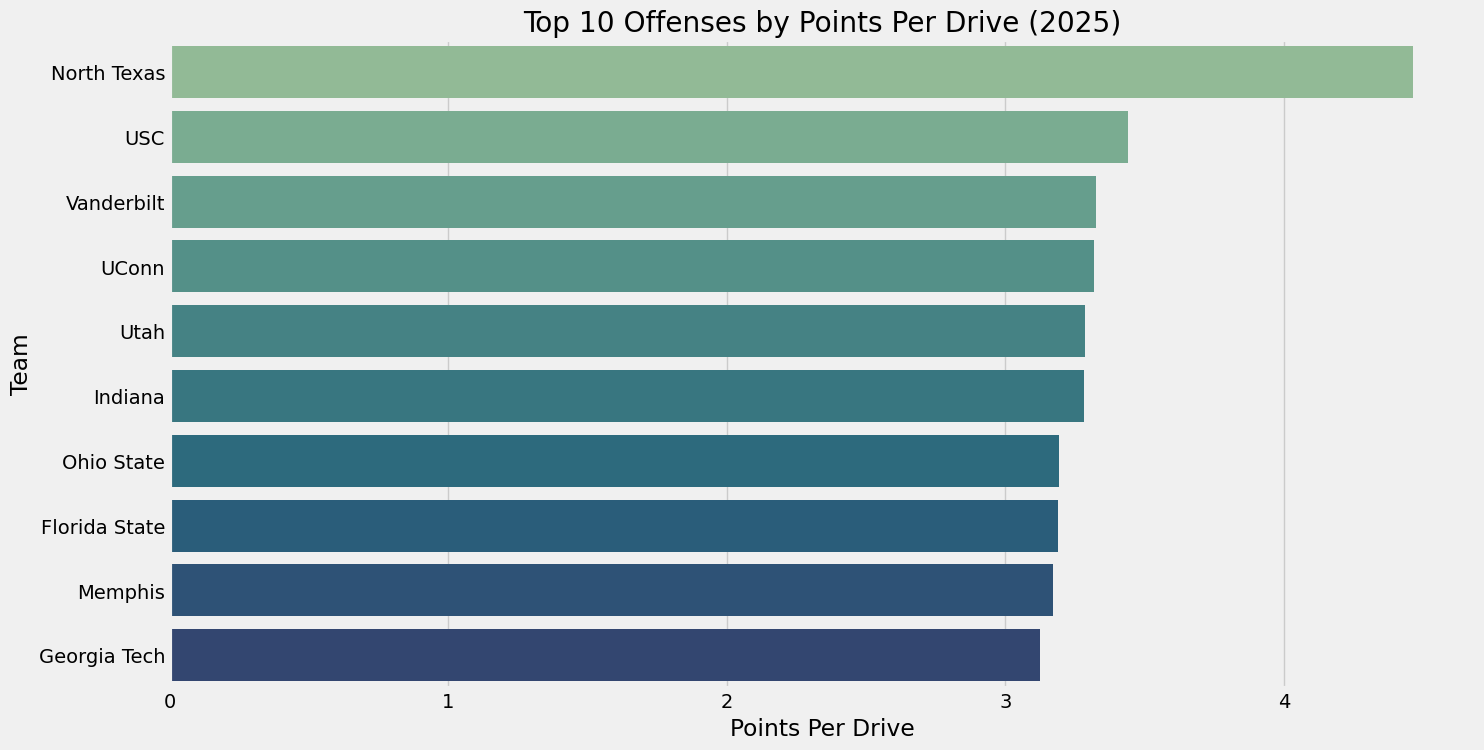

In [24]:
# 📈 Visualize top 10 offenses by PPD

sns.barplot(data=ppd.head(10), x="points_per_drive", y="offense", palette="crest")
plt.title(f"Top 10 Offenses by Points Per Drive ({config.current_year})")
plt.xlabel("Points Per Drive")
plt.ylabel("Team")
plt.show()

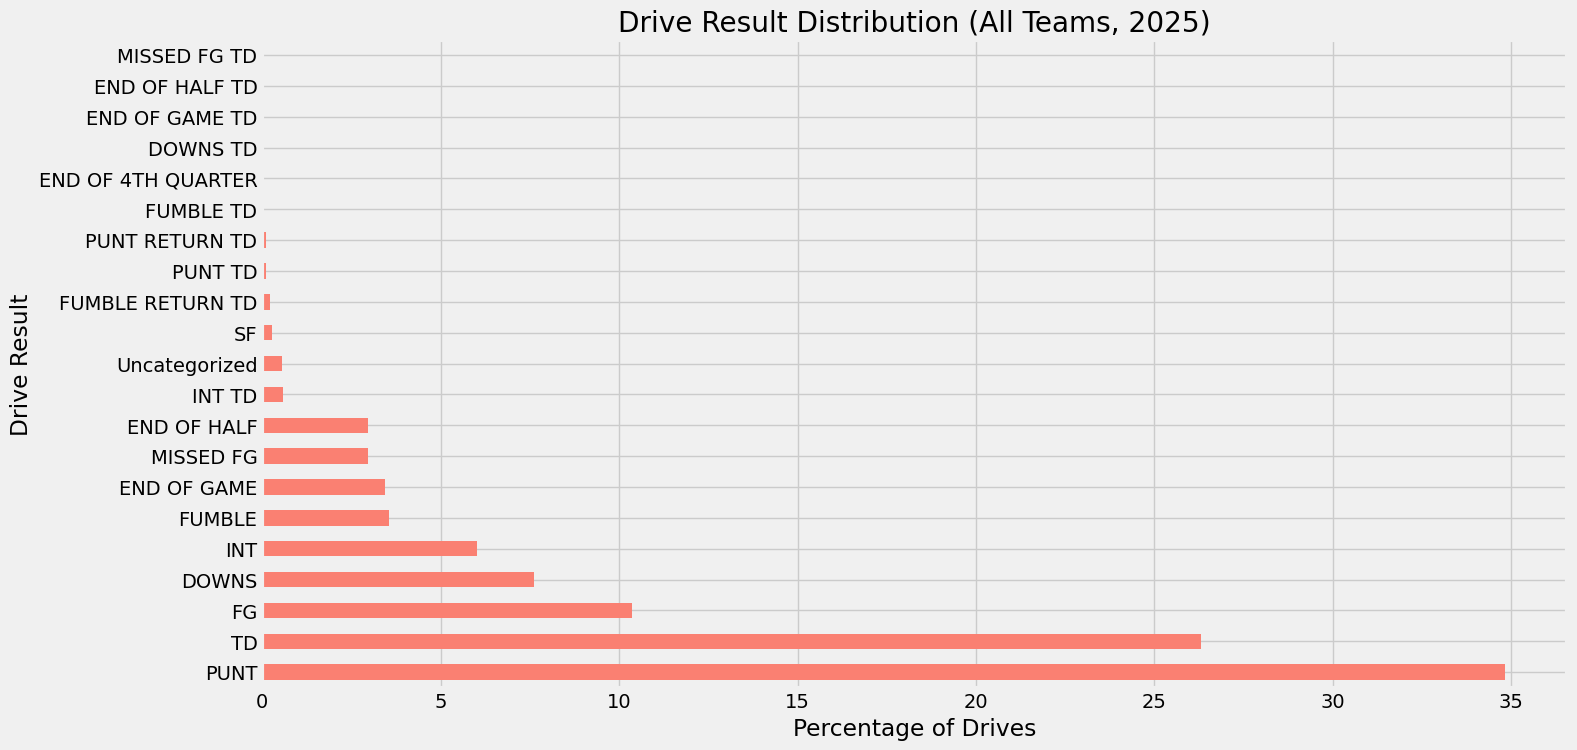

In [25]:
# 🔍 Drive outcome rate breakdown

outcomes = drives["driveResult"].value_counts(normalize=True).mul(100).round(2)
outcomes.plot(kind="barh", color="salmon")
plt.title(f"Drive Result Distribution (All Teams, {config.current_year})")
plt.xlabel("Percentage of Drives")
plt.ylabel("Drive Result")
plt.show()

{"timestamp": "2025-11-25T03:02:15.620276+00:00", "level": "warning", "logger": "py.warnings", "message": "/var/folders/57/ts2cbf317_j7v99p8sk3nwjw0000gn/T/ipykernel_75002/4159216323.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.\n  field_ppd = drives.groupby(\"startYardline_bin\")[\"offensePoints\"].mean().reset_index()\n", "service": "script_ohio", "environment": "development", "taskName": "Task-102"}


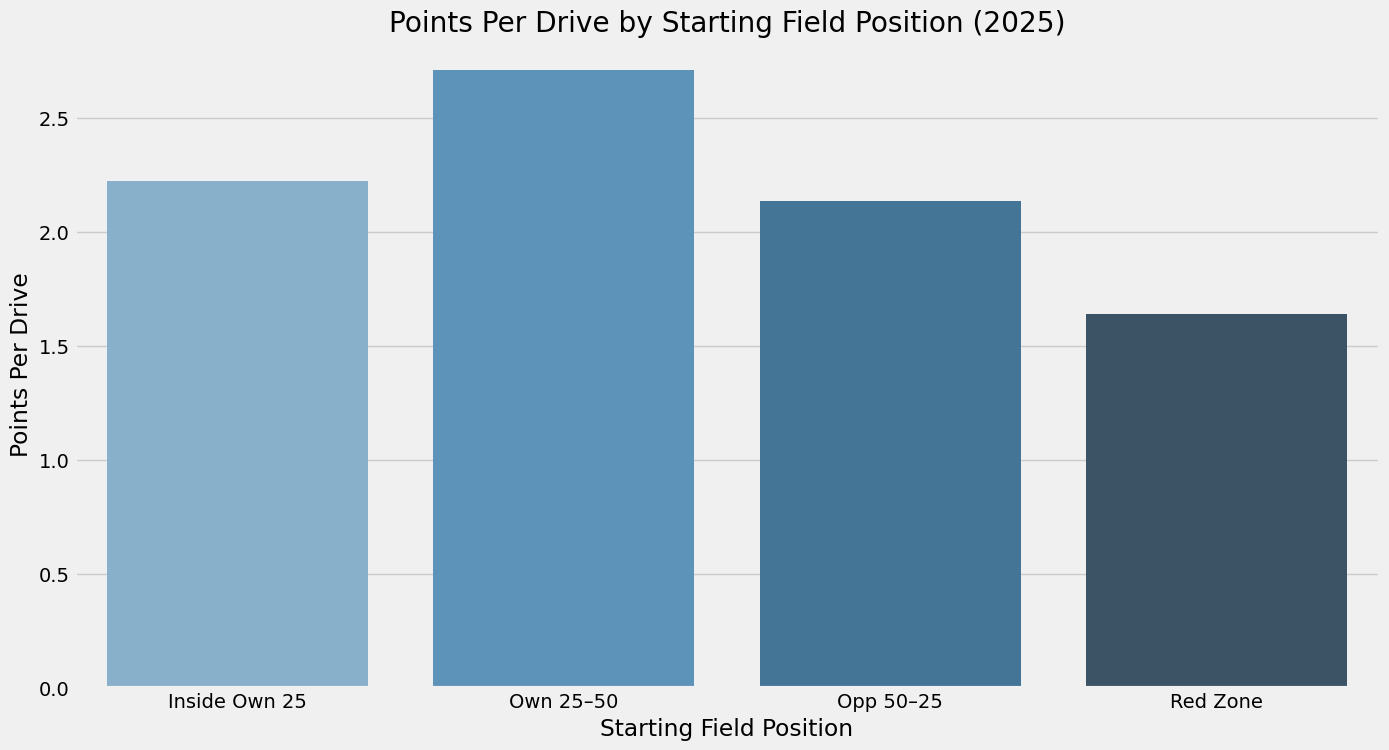

In [26]:
# 🧪 Field position efficiency: Starting yardline buckets

drives["startYardline_bin"] = pd.cut(drives["startYardline"], bins=[0, 25, 50, 75, 100], labels=["Inside Own 25", "Own 25–50", "Opp 50–25", "Red Zone"])
field_ppd = drives.groupby("startYardline_bin")["offensePoints"].mean().reset_index()

sns.barplot(data=field_ppd, x="startYardline_bin", y="offensePoints", palette="Blues_d", hue=field_ppd["startYardline_bin"])
plt.title(f"Points Per Drive by Starting Field Position ({config.current_year})")
plt.xlabel("Starting Field Position")
plt.ylabel("Points Per Drive")
plt.show()

In [27]:
# ✅ Summary

# In this notebook, you:
# - Calculated points per drive using score deltas
# - Identified top offenses by drive efficiency
# - Visualized distribution of drive results
# - Explored impact of field position on scoring

# 🧪 Try This:
# - Filter by quarter, game state, or opponent
# - Compare drive stats by offense vs. defense team
# - Calculate scoring rates (drives ending in TD/FG)